In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

1. Preparacion de Datos
- Cargar datos de consumo energetico y meteorologicos

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# cargar datos de uso de energia
df = pd.read_csv('power_usage_2016_to_2020.csv')

# actualizar columna datetime
n = df.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1h', periods = n))
df['StartDate'] = p1.to_frame().index.to_timestamp()

# convertir fecha a datetime y ordenar
df['StartDate']  = pd.to_datetime(df['StartDate'])
df = df.sort_values('StartDate').reset_index(drop=True)

#verificar valores nulos
#print(df.isnull().sum())

df.head

<bound method NDFrame.head of                 StartDate  Value (kWh)  day_of_week    notes
0     2016-06-01 00:00:00        1.057            2  weekday
1     2016-06-01 01:00:00        1.171            2  weekday
2     2016-06-01 02:00:00        0.560            2  weekday
3     2016-06-01 03:00:00        0.828            2  weekday
4     2016-06-01 04:00:00        0.932            2  weekday
...                   ...          ...          ...      ...
35947 2020-07-07 19:00:00        1.307            1  weekday
35948 2020-07-07 20:00:00        2.872            1  weekday
35949 2020-07-07 21:00:00        2.138            1  weekday
35950 2020-07-07 22:00:00        2.199            1  weekday
35951 2020-07-07 23:00:00        1.809            1  weekday

[35952 rows x 4 columns]>

In [ ]:
# cargar datos meteorologicos
df_weather = pd.read_csv('weather_2016_2020_daily.csv')

m = df_weather.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
df_weather['Date'] = p2.to_frame().index.to_timestamp()

df_weather['date'] = pd.to_datetime(df_weather['Date'])
df_weather = df_weather.sort_values('Date').reset_index(drop=True)

df_weather.head

<bound method NDFrame.head of            Date  Day  Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  \
0    2016-06-01    1        85      74.8        68       74     71.4       66   
1    2016-06-02    2        76      71.2        66       74     70.3       66   
2    2016-06-03    3        79      72.1        68       72     70.0       68   
3    2016-06-04    4        76      71.2        69       73     70.0       66   
4    2016-06-05    5        82      73.8        68       72     70.0       68   
...         ...  ...       ...       ...       ...      ...      ...      ...   
1547 2020-08-26   26        95      83.4        79       79     75.7       73   
1548 2020-08-27   27        99      87.1        78       75     72.0       69   
1549 2020-08-28   28        98      86.5        79       79     77.2       74   
1550 2020-08-29   29        98      87.5        79       79     75.8       72   
1551 2020-08-30   30        97      86.9        78       78     76.3       74  

- Unir ambos dataset usando la fecha como clave

In [ ]:
# unir datos 
# crear columna de fecha sin hora 
df['date_only'] = df['StartDate'].dt.date
df_weather['date_only'] = df_weather['Date'].dt.date

df_combined = df.merge(df_weather, on='date_only', how='left')
df_combined = df_combined.drop('date_only', axis=1)
#df_combined.columns.tolist()

- Codificar categoria (notes) con LabelEncoder

In [28]:
# codificar 'notes'
le = LabelEncoder()
df_combined['notes_encoded'] = le.fit_transform(df_combined['notes'])
df_combined['notes_encoded']

0        2
1        2
2        2
3        2
4        2
        ..
35947    2
35948    2
35949    2
35950    2
35951    2
Name: notes_encoded, Length: 35952, dtype: int64

- Extraer caracteristicas temporales (hora, mes, dia_del_año)

In [29]:
# extraer caracteristicas
df_combined['hour'] = df_combined['StartDate'].dt.hour
df_combined['month'] = df_combined['StartDate'].dt.month
df_combined['day_of_year'] = df_combined['StartDate'].dt.dayofyear

# seleccionar caracteristicas
FEATURES = [
    'Value (kWh)',     # consumo de energia
    'Temp_avg',        # temperatura 
    'Hum_avg',         # humedad 
    'Wind_avg',        # velocidad del viento
    'Press_avg',       # presion atmosferica
    'Precipit',        # precipitacion
    'notes_encoded',   # notas 
    'hour',            # hora del dia
    'month',           # mes del año
    'day_of_year'      # dia del año
]

# verificar que caracteristicas esten disponibles
available_features = [feat for feat in FEATURES if feat in df_combined.columns] 
print(available_features)

['Value (kWh)', 'Temp_avg', 'Hum_avg', 'Wind_avg', 'Press_avg', 'Precipit', 'notes_encoded', 'hour', 'month', 'day_of_year']


- Normalizacion

In [ ]:
# normalizar cada feature individualmente entre 0-1
scalers = {}
scaled_data = df_combined[available_features].copy()

for feature in  available_features:
    scaler = MinMaxScaler()
    scaled_data[feature] = scaler.fit_transform(df_combined[[feature]])
    scalers[feature] = scaler

scaled_data.head

<bound method NDFrame.head of        Value (kWh)  Temp_avg   Hum_avg  Wind_avg  Press_avg  Precipit  \
0         0.155594  0.756410  0.846491  0.354260   0.555556       0.0   
1         0.173457  0.756410  0.846491  0.354260   0.555556       0.0   
2         0.077719  0.756410  0.846491  0.354260   0.555556       0.0   
3         0.119712  0.756410  0.846491  0.354260   0.555556       0.0   
4         0.136008  0.756410  0.846491  0.354260   0.555556       0.0   
...            ...       ...       ...       ...        ...       ...   
35947     0.194767  0.911859  0.659357  0.201794   0.555556       0.0   
35948     0.439987  0.911859  0.659357  0.201794   0.555556       0.0   
35949     0.324976  0.911859  0.659357  0.201794   0.555556       0.0   
35950     0.334535  0.911859  0.659357  0.201794   0.555556       0.0   
35951     0.273425  0.911859  0.659357  0.201794   0.555556       0.0   

       notes_encoded      hour     month  day_of_year  
0           0.666667  0.000000  0.454

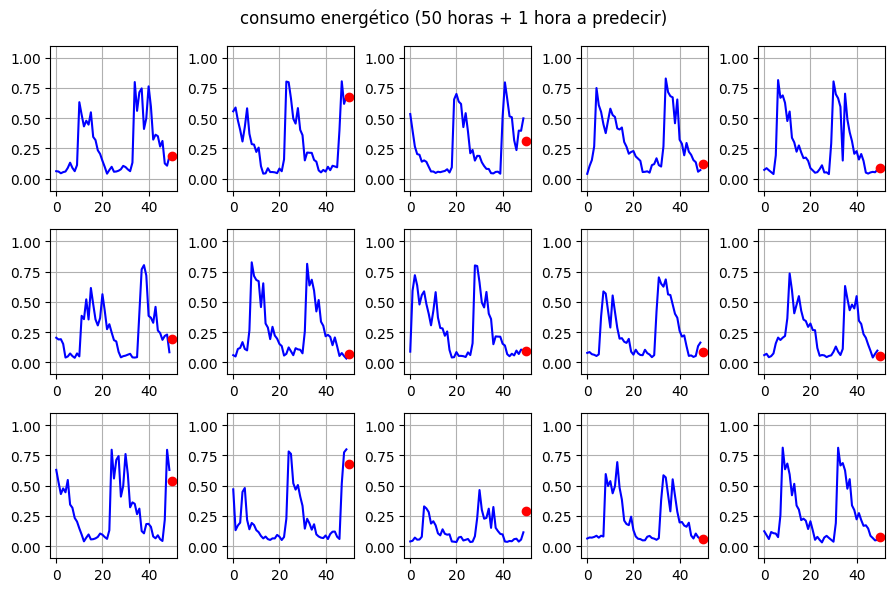

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# solo las primeras 1k horas para la visualizacion
sample_data = scaled_data['Value (kWh)'].values[:1000]

# crear ventanas de 50 horas
n_steps = 50
X = []
for i in range(len(sample_data) - n_steps):
    X.append(sample_data[i:i + n_steps])
X = np.array(X)

# seleccionar 15 series aleatorias
np.random.seed(42)
random_indices = np.random.choice(len(X), 15, replace=False)

plt.figure(figsize=(9, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.plot(X[idx], 'b-', linewidth=1.5)
    plt.plot(n_steps, sample_data[idx + n_steps], 'ro', markersize=6)
    plt.grid(True)
    plt.ylim(-0.1, 1.1)

plt.suptitle('consumo energético (50 horas + 1 hora a predecir)')
plt.tight_layout()
plt.show() 


- Dividir datos:
    - 70% train
    - 20% val
    - 10% test

In [32]:
# dividir train/validation/test
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

2. Creacion de Secuencias
    - Para cada punto en el tiempo:
        - 50 horas de historial
        - predice 5 horas futuras

In [33]:
# crear secuencias 
def create_sequences(data, seq_length=50, prediction_steps=5):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_steps):
        #secuencia de entrada
        seq = data.iloc[i:i + seq_length][FEATURES].values
        #secuencia de salida
        target = data.iloc[i + seq_length:i + seq_length + prediction_steps]['Value (kWh)'].values
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data) 
X_val, y_val = create_sequences(val_data) 
X_test, y_test = create_sequences(test_data)

print(f'train_seq: {X_train.shape}, targets: {y_train.shape}')
print(f'val_seq: {X_val.shape}, targets: {y_val.shape}')
print(f'test_seq: {X_test.shape}, targets: {y_test.shape}')

train_seq: (25111, 50, 10), targets: (25111, 5)
val_seq: (7135, 50, 10), targets: (7135, 5)
test_seq: (3541, 50, 10), targets: (3541, 5)


In [34]:
# convertir a tensores de pytorch
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# crear dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

3. Configuracion de modelos

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#1 RNN Simple
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers= num_layers
        self.output_steps = output_steps

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0) #h0 estado oculto 
        out = self.fc(out[:, -1, :]) # tomar la ultima salida de la secuencia
        return out
    
    '''1. lee los datos uno por uno (paso temporal)
       2. en cada paso, mezcla la entrada actual con su memoria previa (h0)
       3. all final de la secuencia usa el ultimo estado como resumen de todo lo que vio '''

In [ ]:
#2 LSTM - con células de memoria a largo plazo
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers= num_layers
        self.output_steps = output_steps

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0)) # h0 estado oculto - c0 estado de celda inicial (memoria largo plazo)
        out = self.fc(out[:, -1, :]) 
        return out

'''arquitectura basad en un sistema de celdas de memoria (mantienen la informacion a traves de los
distintos pasos temporales) y compuertas "gates" (que controlan el flujo de la informacion a lo 
largo del tiempo).
- forget gate (compuerta del olvido): decide que informacion del estado previo debe olvidarse. 
Utiliza la entrada actual y el estado oculto anterior aplicando sigmoide (0,1).
- input gate (compuerta de entrada): controla cuanta informacion nueva se añade al estado de 
la celda.
- output gate (compuerta de salida): determina cuanta informacion del estado de la celda se 
muestra como salida y se transmite al siguiente estado oculto.  '''

In [ ]:
#3 GRU - version simplificada de LSTM
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers= num_layers
        self.output_steps = output_steps

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out
    
    '''procesa cada paso temporal y actualiza el estado oculto h0 usando puertas (update y reset)'''

3. Ciclo de entrenamiento. para cada epoca:
    - fase de entrenamiento
    - fase de validacion.
    - early stopping (9)

In [39]:
# funcion fit
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.to(device)
    train_losses, val_losses = [], []

    best_val_loss = float('inf')
    patience = 9
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # entrenamiento
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # validacion
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        # guardar perdidas
        avg_train_loss= train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # eraly stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy() # guardar
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'es en poch {epoch+1}')
            model.load_state_dict(best_model_state) # cargar
            break

        if (epoch + 1) % 10 == 0:
            print(f'epoch [{epoch+1}/{epochs}], train loss: {avg_train_loss:.6f}, val loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses

5. Flujo de datos en el modelo
- Forward pass:
    - Input: (batch_size, 50, 10)  # lotes, secuencia, features
    - RNN/LSTM/GRU: procesa secuencia paso a paso
    - Hidden States: (batch_size, 50, 64)  # estados ocultos en cada paso
    - Toma último hidden state: (batch_size, 64)
    - Capa lineal: (batch_size, 5)  # predicción 5 pasos futuros

In [ ]:
# configurar modelos
input_size = len(FEATURES)
hidden_size = 64
num_layers = 2 # capas recurrentes
output_steps = 5

# crear modelos
models = {
    'SimpleRNN': SimpleRNN(input_size, hidden_size,num_layers, output_steps),
    'LST': LSTM(input_size, hidden_size,num_layers, output_steps),
    'GRU': GRU(input_size, hidden_size,num_layers, output_steps),
}

6. Optimizacion
- Optimizador: Adam 
- Perdida: MSE
- Regularizacion: weight decay + dropout

In [41]:
# entrenar y comparar modelos
EPOCHS = 200
results = {}
criterion = nn.MSELoss()

for model_name, model in models.items():
    print(model_name)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, EPOCHS
    )

    results[model_name] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses
    } 

SimpleRNN
epoch [10/200], train loss: 0.009306, val loss: 0.013292
epoch [20/200], train loss: 0.009219, val loss: 0.012141
epoch [30/200], train loss: 0.008391, val loss: 0.010155
epoch [40/200], train loss: 0.008255, val loss: 0.008958
epoch [50/200], train loss: 0.008108, val loss: 0.007800
epoch [60/200], train loss: 0.008089, val loss: 0.007576
epoch [70/200], train loss: 0.008069, val loss: 0.007353
es en poch 79
LST
epoch [10/200], train loss: 0.009109, val loss: 0.012286
epoch [20/200], train loss: 0.008298, val loss: 0.007001
epoch [30/200], train loss: 0.008024, val loss: 0.006736
epoch [40/200], train loss: 0.007899, val loss: 0.006696
epoch [50/200], train loss: 0.007749, val loss: 0.006671
es en poch 56
GRU
epoch [10/200], train loss: 0.008685, val loss: 0.010679
epoch [20/200], train loss: 0.008007, val loss: 0.007813
epoch [30/200], train loss: 0.007797, val loss: 0.007399
epoch [40/200], train loss: 0.007731, val loss: 0.007109
epoch [50/200], train loss: 0.007642, val 

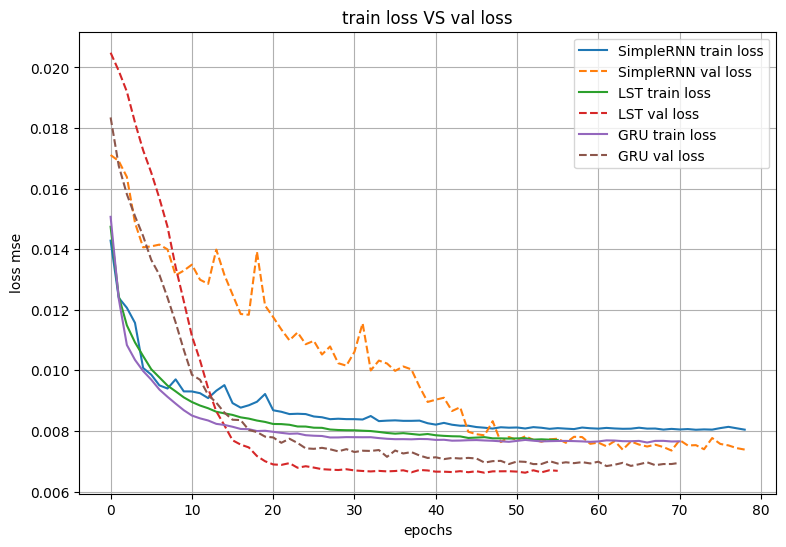

In [42]:
plt.figure(figsize=(9, 6))

for model_name, result in results.items():
    plt.plot(result['train_losses'], label=f'{model_name} train loss')
    plt.plot(result['val_losses'], '--', label=f'{model_name} val loss')

plt.xlabel('epochs')
plt.ylabel('loss mse')
plt.title('train loss VS val loss')
plt.legend()
plt.grid(True)
plt.show()

- LSTM tiene curvas mas bajas y estables
- GRU muy cercana a LSTM
- SimpleRNN consistentemente mas alto
- brecha train-val, buena generalizacion

LSTM el mejor:
- Logra la menor perdida de validacion (0.006671)
- Converge mas rapido (56 epocas)
- muestra el mejor equilibrio entre capacidad predictiva y eficiencia
GRU es una buena alternativa como un modelo mas simple.

Recomendaciones:
- ajustar hiperparametros (hidden_size = 128, num_layers = 3, learning_rate = 0.0005)
- tecnicas de regularizacion (dropout (0.4-0.5))

7. Evaluacion final

In [43]:
# evaluacion
def evaluate_model(model, test_loader, criterion):
    model.eval() # desactiva dropout, batchnorm, etc
    test_loss  = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss, np.array(predictions), np.array(actuals)

In [44]:
# evaluar todos los modelos
test_results = {}
for model_name in models.keys():
    test_loss, predictions, actuals = evaluate_model(
        results[model_name]['model'], test_loader, criterion
    )
    test_results[model_name] = {
        'test_loss': test_loss,
        'predictions': predictions,
        'actuals': actuals
    }
    print(f'{model_name}: test loss = {test_loss:.6f}')

SimpleRNN: test loss = 0.008055
LST: test loss = 0.007560
GRU: test loss = 0.007127


Analisis de mejor a peor:
- GRU - test loss: 0.007127
    - buen equilibrio entre entrenamiento y validacion
    - se detuvo en epoca 71
- LSTM - test loss: 0.007560
    - buen rendimiento
    - convergencia rapida
    - ligeramente peor que GRU
- SimpleRNN - test loss: 0.008055
    - mayor sobreajuste
    - se detuvo en epoca 79 

Datos crudos -> preprocesamiento -> secuencias -> entrenamiento -> validacion -> early stopping -> evaluacion final